In [1]:
pip install tensorflow scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, InceptionV3, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_dir = "Segmented Medicinal Leaf Images"

In [3]:
# Paramètres du modèle
img_height = 224
img_width = 224
batch_size = 32
epochs = 20
k_folds = 5
num_classes = len(os.listdir(data_dir))
input_shape = (img_height, img_width, 3)

In [4]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [5]:

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Pour plusieurs classes
    subset='training'  # Utilisez l'ensemble d'entraînement
)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Utilisez l'ensemble de validation pour les tests
)



Found 1479 images belonging to 30 classes.
Found 356 images belonging to 30 classes.


In [6]:
# Charger les modèles pré-entraînés
base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


In [7]:
# Ajouter des couches personnalisées
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024, activation='relu')(x1)
predictions1 = Dense(num_classes, activation='softmax')(x1)




In [8]:

# Créer les modèles complets
model1 = Model(inputs=base_model1.input, outputs=predictions1)


In [9]:
# Utilisation de l'arrêt précoce
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [10]:
# Compiler et entraîner les modèles individuels
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

hist=model1.fit(train_generator,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=test_generator)


Epoch 1/20
47/47 [==============================] - 381s 8s/step - loss: 2.0210 - accuracy: 0.5463 - val_loss: 2.6549 - val_accuracy: 0.2640
Epoch 2/20
47/47 [==============================] - 388s 8s/step - loss: 0.3431 - accuracy: 0.9459 - val_loss: 2.3714 - val_accuracy: 0.3539
Epoch 3/20
47/47 [==============================] - 353s 7s/step - loss: 0.1210 - accuracy: 0.9784 - val_loss: 2.1383 - val_accuracy: 0.3904
Epoch 4/20
47/47 [==============================] - 341s 7s/step - loss: 0.0763 - accuracy: 0.9872 - val_loss: 1.9200 - val_accuracy: 0.4522
Epoch 5/20
47/47 [==============================] - 338s 7s/step - loss: 0.0507 - accuracy: 0.9912 - val_loss: 1.7301 - val_accuracy: 0.4803
Epoch 6/20
47/47 [==============================] - 349s 7s/step - loss: 0.0261 - accuracy: 0.9946 - val_loss: 1.6572 - val_accuracy: 0.4775
Epoch 7/20
47/47 [==============================] - 342s 7s/step - loss: 0.0183 - accuracy: 0.9980 - val_loss: 1.6558 - val_accuracy: 0.5112
Epoch 8/20
47

In [11]:
# Évaluer les modèles individuels sur l'ensemble de test
test_loss1, test_accuracy1 = model1.evaluate(test_generator)


print("MobileNetV2 Accuracy:", test_accuracy1)

12/12 [==============================] - 27s 2s/step - loss: 1.0940 - accuracy: 0.6882
MobileNetV2 Accuracy: 0.6882022619247437


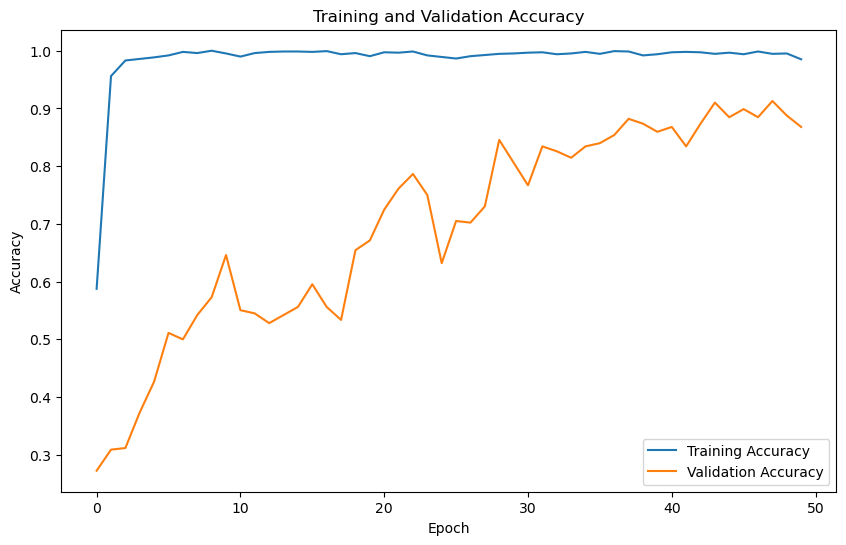

In [14]:
import matplotlib.pyplot as plt

# Récupérez l'historique de l'entraînement (où `history` est l'objet retourné par `model.fit`)
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Tracez les courbes d'accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [26]:

# Compiler et entraîner les modèles individuels #fine-tunning
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
47/47 [==============================] - 875s 16s/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.8711 - val_accuracy: 0.7865
Epoch 2/5
47/47 [==============================] - 713s 15s/step - loss: 0.0101 - accuracy: 0.9980 - val_loss: 1.0971 - val_accuracy: 0.7669
Epoch 3/5
47/47 [==============================] - 705s 15s/step - loss: 0.0099 - accuracy: 0.9980 - val_loss: 1.0622 - val_accuracy: 0.7865
Epoch 4/5
47/47 [==============================] - 680s 14s/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.8468 - val_accuracy: 0.8455
Epoch 5/5
47/47 [==============================] - 937s 20s/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 0.7963 - val_accuracy: 0.8315


In [27]:
# Évaluer les modèles individuels sur l'ensemble de test
test_loss1, test_accuracy1 = model1.evaluate(test_generator)


print("MobileNetV2 Accuracy:", test_accuracy1)

12/12 [==============================] - 72s 6s/step - loss: 0.9146 - accuracy: 0.8315
MobileNetV2 Accuracy: 0.8314606547355652


In [28]:
# Compiler et entraîner les modèles individuels #fine-tunning
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
47/47 [==============================] - 1139s 21s/step - loss: 0.0265 - accuracy: 0.9932 - val_loss: 1.3653 - val_accuracy: 0.7781
Epoch 2/5
47/47 [==============================] - 798s 17s/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.7447 - val_accuracy: 0.8736
Epoch 3/5
47/47 [==============================] - 740s 16s/step - loss: 0.0130 - accuracy: 0.9953 - val_loss: 0.9438 - val_accuracy: 0.8567
Epoch 4/5
47/47 [==============================] - 708s 15s/step - loss: 0.0175 - accuracy: 0.9912 - val_loss: 0.3556 - val_accuracy: 0.9073
Epoch 5/5
47/47 [==============================] - 697s 15s/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 0.7431 - val_accuracy: 0.8455


In [29]:
# Évaluer les modèles individuels sur l'ensemble de test
test_loss1, test_accuracy1 = model1.evaluate(test_generator)


print("MobileNetV2 Accuracy:", test_accuracy1)

12/12 [==============================] - 73s 6s/step - loss: 0.7112 - accuracy: 0.8736
MobileNetV2 Accuracy: 0.8735954761505127


In [1]:
# Compiler et entraîner les modèles individuels #fine-tunning
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'model1' is not defined